In [ ]:

import os
import pickle
import sys
import numpy as np
import matplotlib.pylab as plt
import random
import collections
from abc import ABC, abstractmethod

In [ ]:

class Game:
    def __init__(self, agent, trainer=None):
        self.agent = agent
        self.trainer = trainer
        self.board = [['-', '-', '-'], ['-', '-', '-'], ['-', '-', '-']]

    def playerMove(self):
        action = self.trainer.makeMove(self.board)
        self.board[action[0]][action[1]] = 'X'
    

    def agentMove(self, action):
        self.board[action[0]][action[1]] = 'O'

    def checkForWin(self, key):
        a = [self.board[0][0], self.board[1][1], self.board[2][2]]
        b = [self.board[0][2], self.board[1][1], self.board[2][0]]
        if a.count(key) == 3 or b.count(key) == 3:
            return True
        for i in range(3):
            col = [self.board[0][i], self.board[1][i], self.board[2][i]]
            row = [self.board[i][0], self.board[i][1], self.board[i][2]]
            if col.count(key) == 3 or row.count(key) == 3:
                return True
        return False

    def checkForDraw(self):
        draw = True
        for row in self.board:
            for elt in row:
                if elt == '-':
                    draw = False
        return draw

    def checkForEnd(self, key):
        if self.checkForWin(key):
            return 1
        elif self.checkForDraw():
            return 0
        return -1

    def playGame(self, player_first):
        if player_first:
            self.playerMove()
        prev_state = getStateKey(self.board)
        prev_action = self.agent.get_action(prev_state)
        while True:
            self.agentMove(prev_action)
            check = self.checkForEnd('O')
            if not check == -1:
                reward = check
                break
            self.playerMove()
            check = self.checkForEnd('X')
            if not check == -1:
                reward = -1*check
                break
            else:
                reward = 0
            new_state = getStateKey(self.board)
            new_action = self.agent.get_action(new_state)
            self.agent.update(prev_state, new_state, prev_action, new_action, reward)
            prev_state = new_state
            prev_action = new_action
        self.agent.update(prev_state, None, prev_action, None, reward)

    def start(self):
        if random.random() < 0.5:
          self.playGame(player_first=False)
        else:
          self.playGame(player_first=True)
def getStateKey(board):
    key = ''
    for row in board:
        for elt in row:
            key += elt
    return key



In [ ]:

class Trainer:
    def win(self, board, key='X'):
        a = [board[0][0], board[1][1], board[2][2]]
        b = [board[0][2], board[1][1], board[2][0]]
        if a.count('-') == 1 and a.count(key) == 2:
            ind = a.index('-')
            return ind, ind
        elif b.count('-') == 1 and b.count(key) == 2:
            ind = b.index('-')
            if ind == 0:
                return 0, 2
            elif ind == 1:
                return 1, 1
            else:
                return 2, 0
     
        for i in range(3):
            c = [board[0][i], board[1][i], board[2][i]]
            d = [board[i][0], board[i][1], board[i][2]]
            if c.count('-') == 1 and c.count(key) == 2:
                ind = c.index('-')
                return ind, i
            elif d.count('-') == 1 and d.count(key) == 2:
                ind = d.index('-')
                return i, ind
        return None

    def blockWin(self, board):
        return self.win(board, key='O')

    def fork(self, board):
        
 
        if board[1][0] == 'X' and board[0][1] == 'X':
            if board[0][0] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 0, 0
            elif board[1][1] == '-' and board[2][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[1][0] == 'X' and board[2][1] == 'X':
            if board[2][0] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 2, 0
            elif board[1][1] == '-' and board[0][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[2][1] == 'X' and board[1][2] == 'X':
            if board[2][2] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 2, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[0][1] == '-':
                return 1, 1
        elif board[1][2] == 'X' and board[0][1] == 'X':
            if board[0][2] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 0, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[2][1] == '-':
                return 1, 1
       
        elif board[0][0] == 'X' and board[2][2] == 'X':
            if board[1][0] == '-' and board[2][1] == '-' and board[2][0] == '-':
                return 2, 0
            elif board[0][1] == '-' and board[1][2] == '-' and board[0][2] == '-':
                return 0, 2
        elif board[2][0] == 'X' and board[0][2] == 'X':
            if board[2][1] == '-' and board[1][2] == '-' and board[2][2] == '-':
                return 2, 2
            elif board[1][0] == '-' and board[0][1] == '-' and board[0][0] == '-':
                return 0, 0
        return None

    def blockFork(self, board):
        corners = [board[0][0], board[2][0], board[0][2], board[2][2]]
        # Check all adjacent side middles
        if board[1][0] == 'O' and board[0][1] == 'O':
            if board[0][0] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 0, 0
            elif board[1][1] == '-' and board[2][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[1][0] == 'O' and board[2][1] == 'O':
            if board[2][0] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 2, 0
            elif board[1][1] == '-' and board[0][1] == '-' and board[1][2] == '-':
                return 1, 1
        elif board[2][1] == 'O' and board[1][2] == 'O':
            if board[2][2] == '-' and board[2][0] == '-' and board[0][2] == '-':
                return 2, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[0][1] == '-':
                return 1, 1
        elif board[1][2] == 'O' and board[0][1] == 'O':
            if board[0][2] == '-' and board[0][0] == '-' and board[2][2] == '-':
                return 0, 2
            elif board[1][1] == '-' and board[1][0] == '-' and board[2][1] == '-':
                return 1, 1
        elif corners.count('-') == 1 and corners.count('O') == 2:
            return 1, 2
        elif board[0][0] == 'O' and board[2][2] == 'O':
            if board[1][0] == '-' and board[2][1] == '-' and board[2][0] == '-':
                return 2, 0
            elif board[0][1] == '-' and board[1][2] == '-' and board[0][2] == '-':
                return 0, 2
        elif board[2][0] == 'O' and board[0][2] == 'O':
            if board[2][1] == '-' and board[1][2] == '-' and board[2][2] == '-':
                return 2, 2
            elif board[1][0] == '-' and board[0][1] == '-' and board[0][0] == '-':
                return 0, 0
        return None

    def center(self, board):
       
        if board[1][1] == '-':
            return 1, 1
        return None

    def corner(self, board):
        if board[0][0] == 'O' and board[2][2] == '-':
            return 2, 2
        elif board[2][0] == 'O' and board[0][2] == '-':
            return 0, 2
        elif board[0][2] == 'O' and board[2][0] == '-':
            return 2, 0
        elif board[2][2] == 'O' and board[0][0] == '-':
            return 0, 0
        elif board[0][0] == '-':
            return 0, 0
        elif board[2][0] == '-':
            return 2, 0
        elif board[0][2] == '-':
            return 0, 2
        elif board[2][2] == '-':
            return 2, 2
        return None

    def sideEmpty(self, board):
       
        if board[1][0] == '-':
            return 1, 0
        elif board[2][1] == '-':
            return 2, 1
        elif board[1][2] == '-':
            return 1, 2
        elif board[0][1] == '-':
            return 0, 1
        return None

    def randomMove(self, board):
        
        possibles = []
        for i in range(3):
            for j in range(3):
                if board[i][j] == '-':
                    possibles += [(i, j)]
        return possibles[random.randint(0, len(possibles)-1)]

    def makeMove(self, board):
        a = self.win(board)
        if a is not None:
            return a
        a = self.blockWin(board)
        if a is not None:
            return a
        a = self.fork(board)
        if a is not None:
            return a
        a = self.blockFork(board)
        if a is not None:
            return a
        a = self.center(board)
        if a is not None:
            return a
        a = self.corner(board)
        if a is not None:
            return a
        a = self.sideEmpty(board)
        if a is not None:
            return a
        return self.randomMove(board)

In [ ]:



class Learner(ABC):
    def __init__(self, alpha, gamma, eps, eps_decay=0.):
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.eps_decay = eps_decay
        self.actions = []
        for i in range(3):
            for j in range(3):
                self.actions.append((i,j))
     
        self.Q = {}
        for action in self.actions:
            self.Q[action] = collections.defaultdict(int)
       
        self.rewards = []

    def get_action(self, s):
        possible_actions = [a for a in self.actions if s[a[0]*3 + a[1]] == '-']
        if random.random() < self.eps:
          
            action = possible_actions[random.randint(0,len(possible_actions)-1)]
        else:
        
            values = np.array([self.Q[a][s] for a in possible_actions])
    
            ix_max = np.where(values == np.max(values))[0]
            if len(ix_max) > 1:
               
                ix_select = np.random.choice(ix_max, 1)[0]
            else:
               
                ix_select = ix_max[0]
            action = possible_actions[ix_select]

       
        self.eps *= (1.-self.eps_decay)

        return action


class Qlearner(Learner):
    def __init__(self, alpha, gamma, eps, eps_decay=0.):
        super().__init__(alpha, gamma, eps, eps_decay)

    def update(self, s, s_, a, a_, r):
        if s_ is not None:
            possible_actions = [action for action in self.actions if s_[action[0]*3 + action[1]] == '-']
            Q_options = [self.Q[action][s_] for action in possible_actions]

            self.Q[a][s] += self.alpha*(r + self.gamma*max(Q_options) - self.Q[a][s])
        else:

            self.Q[a][s] += self.alpha*(r - self.Q[a][s])


        self.rewards.append(r)


In [ ]:
def plot_agent_reward(rewards):
    plt.plot(np.cumsum(rewards))
    plt.title('Agent Cumulative Reward vs. Iteration')
    plt.ylabel('Reward')
    plt.xlabel('Episode')
    plt.show()

Games played: 1000


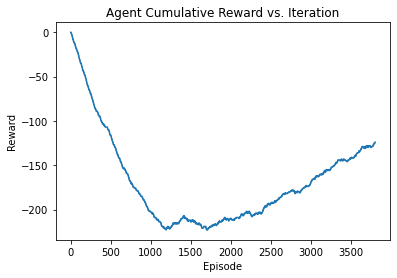

Games played: 2000


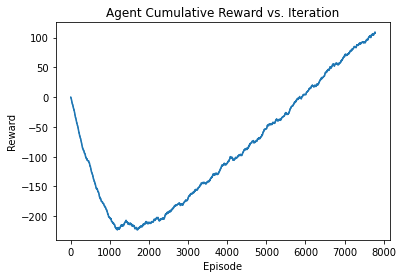

Games played: 3000


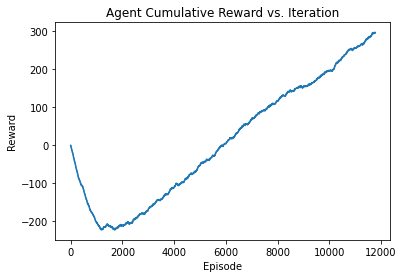

Games played: 4000


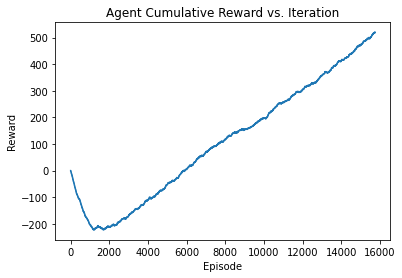

Games played: 5000


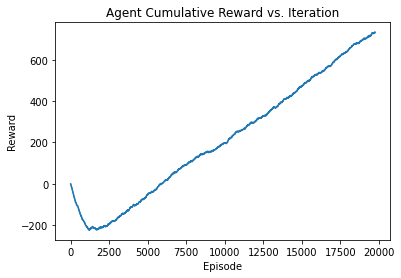

In [ ]:
alpha=0.5
gamma=0.9
epsilon=0.1
count=0
trainer = Trainer()
agent = Qlearner(alpha,gamma,epsilon)
for x in range(5):
  while count <= 1000*(x+1):
          game = Game(agent, trainer=trainer)
          game.start()
          count += 1
          
  print("Games played: "+str(count-1))
  plot_agent_reward(agent.rewards)

